In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [29]:
from __future__ import annotations

class Value():
    def __init__(self, data: int | float, children = (), op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other: Value | int | float):
        addend = other if isinstance(other, Value) else Value(other, label=f'{other}')
        out = Value(self.data + addend.data, children = (self, addend), op = '+', label='R_+')

        def _backward():
            self.grad += 1.0 * out.grad
            addend.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out

    def __radd__(self, other: Value | int | float):
        return self + other

    def __sub__(self, other: Value | int | float):
        return self + -other

    def __rsub__(self, other: Value | int | float):
        return (self * -1) + other

    def __mul__(self, other: Value | int | float):
        multiplier = other if isinstance(other, Value) else Value(other, label=f'{other}')
        out = Value(self.data * multiplier.data, children = (self, multiplier), op = '*', label='R_*')
        
        def _backward(): 
            self.grad += multiplier.data * out.grad
            multiplier.grad += self.data * out.grad

        out._backward = _backward
            
        return out

    def __rmul__(self, other: Value | int | float):
        return self * other

    def __pow__(self, index: int | float):
        out = Value(self.data ** index, children = (self, ), op = '^', label='R_^')

        def _backward():
            self.grad += index * (self.data ** (index - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other: Value | int | float):
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def tanh(self):
        t = (math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1)
        out = Value(t, children = (self, ), op = 'tanh', label='R_tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(5.0, label='c')
L = (a + 1.0) * b + c; L.label = 'L'

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

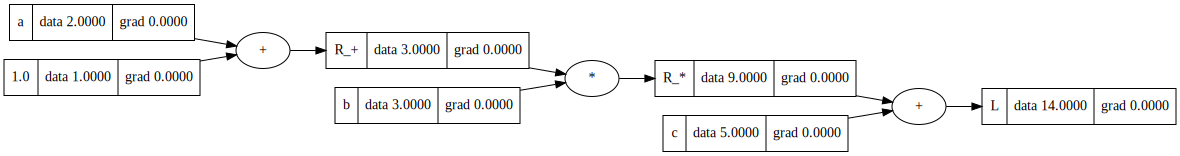

In [287]:
draw_dot(L)

In [5]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(5.0, label='c')
    L = (a + 1.0) * b + c; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(3.0, label='b')
    c = Value(5.0, label='c')
    L = (a + 1.0) * b + c; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

3.0000000000001137


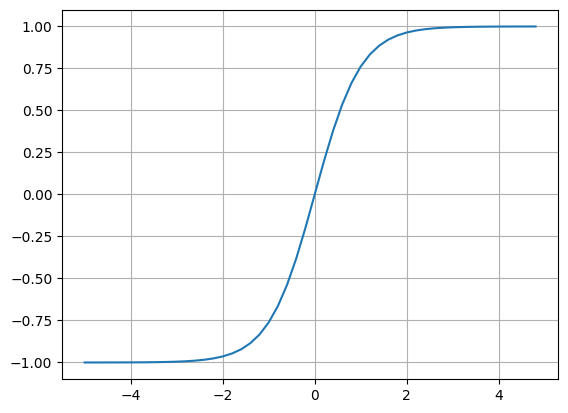

In [289]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [291]:
o.backward()

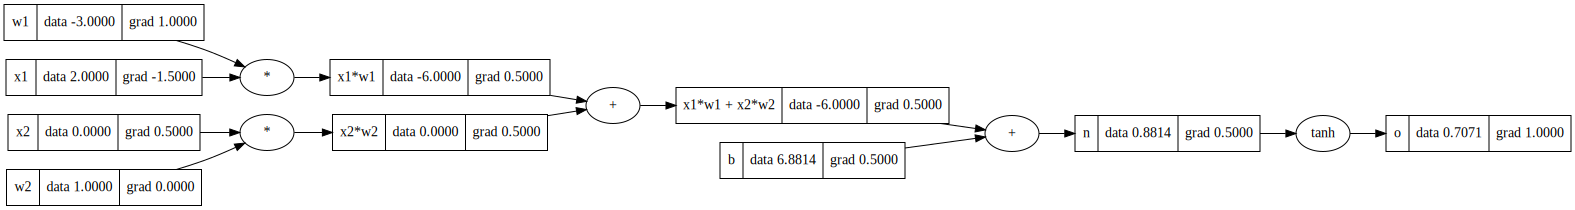

In [292]:
draw_dot(o)

In [7]:
class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1, 1), label=f'w{i + 1}') for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, x: list[int | float]) -> Value:
        act = sum((p * q for p, q in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    @property
    def parameters(self) -> list[Value]:
        return self.w + [self.b]

N = Neuron(3)
N([2.0, 5.0, 3.0])

Value(data=0.9814516695490008, grad=0.0)

In [8]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: list[int | float]) -> list[Value] | Value:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    @property
    def parameters(self) -> list[Value]:
        return [p for neuron in self.neurons for p in neuron.parameters]

layer = Layer(3, 2)
layer([2.0, 5.0, 3.0])

[Value(data=-0.7423077845959181, grad=0.0),
 Value(data=0.9430097000483744, grad=0.0)]

In [21]:
class MultilayerPerceptron:
    def __init__(self, n_inputs: int, n_npl: list[int]):
        sizes = [n_inputs] + n_npl
        self.layers = [Layer(sizes[i], sizes[i + 1]) for i in range(len(n_npl))]

    def __call__(self, x: list[int | float]):
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def parameters(self) -> list[Value]:
        return [p for layer in self.layers for p in layer.parameters]

    def zero_grad(self):
        for p in self.parameters:
            p.grad = 0.0

mlp = MultilayerPerceptron(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
res = mlp(x)

In [28]:
a = Value(2.0, label='a')
-a

TypeError: bad operand type for unary -: 'Value'

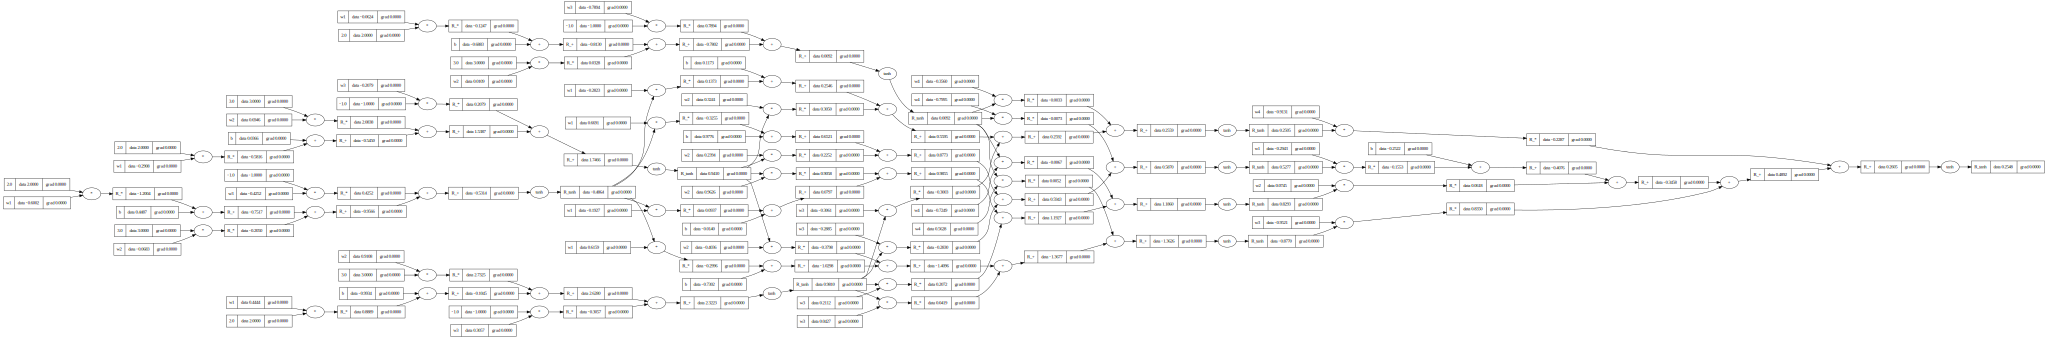

In [317]:
draw_dot(res)

In [22]:
xs = [
  [3.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

mlp = MultilayerPerceptron(3, [4, 4, 1])

ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.7641751470811674, grad=0.0),
 Value(data=-0.5240343932936696, grad=0.0),
 Value(data=-0.5541031079340296, grad=0.0),
 Value(data=-0.8301865966100286, grad=0.0)]

In [23]:
# Error
[(yout - ygt) for yout, ygt in zip(ypred, ys)]

[Value(data=-1.7641751470811675, grad=0.0),
 Value(data=0.47596560670633037, grad=0.0),
 Value(data=0.4458968920659704, grad=0.0),
 Value(data=-1.8301865966100286, grad=0.0)]

In [24]:
# Squared Error
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
loss.backward()
loss

Value(data=6.8872642251112755, grad=1.0)

In [25]:
# training
for p in mlp.parameters:
    p.data += -0.01 * p.grad

ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
loss.backward()
loss

Value(data=6.582830758717859, grad=1.0)

In [27]:
# Full implementation example with the training loop

xs = [
  [3.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

mlp = MultilayerPerceptron(3, [4, 4, 1])

for k in range(20):
    # Forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
    print(k, loss.data)
    
    # Zero Grad
    mlp.zero_grad()

    # Backward Pass
    loss.backward()

    # Update
    for p in mlp.parameters:
        p.data += -0.05 * p.grad

0 5.464813836612618
1 3.437944576227845
2 2.0803094904953796
3 1.2072443163365254
4 0.6748977675310189
5 0.4076363543623545
6 0.2756804079941271
7 0.20317616504221025
8 0.1589080077706858
9 0.12958068247436746
10 0.1089228219404944
11 0.09367647057262085
12 0.08200782662986833
13 0.07281541664689063
14 0.06540173852247004
15 0.05930547128987054
16 0.054210235464694945
17 0.049892307902862976
18 0.046189293456174854
19 0.042980621687104384


In [381]:
ypred

[Value(data=0.999999999191605, grad=-1.6167900351859998e-09),
 Value(data=-0.9999999999996212, grad=7.576161920042068e-13),
 Value(data=-0.999999999999635, grad=7.300826609935029e-13),
 Value(data=0.9999999991892269, grad=-1.621546230623494e-09)]